<a href="https://colab.research.google.com/github/bubabi/covid-19-forecasting/blob/colab_dev/ARIMA_SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/dataset/data"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
countries_useful_features.csv  covid19-global-forecasting-week-4
covid_19_clean_complete.csv    covid19-global-forecasting-week-5


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.dates import DateFormatter
import datetime
import itertools
import matplotlib.dates as mdates
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set()

plt.style.use('bmh')
%matplotlib inline
plt.rcParams['figure.figsize'] = [9.5, 6]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
train = pd.read_csv("/content/drive/My Drive/dataset/data/covid19-global-forecasting-week-4/train.csv")
test = pd.read_csv("/content/drive/My Drive/dataset/data/covid19-global-forecasting-week-4/test.csv")
clean_complete_df = pd.read_csv('/content/drive/My Drive/dataset/data/covid_19_clean_complete.csv', parse_dates=['Date'])
useful_features = pd.read_csv("/content/drive/My Drive/dataset/data/countries_useful_features.csv")

In [4]:
clean_complete_df['Active'] = clean_complete_df['Confirmed'] - clean_complete_df['Deaths'] - clean_complete_df['Recovered']
df = clean_complete_df.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
df.head()

,Date,Country/Region,Confirmed,Deaths,Recovered,Active
0,2020-01-22,Afghanistan,0,0,0,0
1,2020-01-22,Albania,0,0,0,0
2,2020-01-22,Algeria,0,0,0,0
3,2020-01-22,Andorra,0,0,0,0
4,2020-01-22,Angola,0,0,0,0


In [5]:
print("The lowest date in the data set is", df['Date'].min() ,"and the highest", df['Date'].max())

The lowest date in the data set is 2020-01-22 00:00:00 and the highest 2020-05-16 00:00:00


In [6]:
# date:string -> date:datatime
train['Date'] = pd.to_datetime(train['Date'], format = '%Y-%m-%d')
train[train.select_dtypes(['float64']).columns] = train.select_dtypes(['float64']).apply(lambda x: x.astype('int64'))
test['Date'] = pd.to_datetime(test['Date'], format = '%Y-%m-%d')
test[test.select_dtypes(['float64']).columns] = test.select_dtypes(['float64']).apply(lambda x: x.astype('int64'))

df.dtypes

Date              datetime64[ns]
Country/Region            object
Confirmed                  int64
Deaths                     int64
Recovered                  int64
Active                     int64
dtype: object

In [7]:
train.fillna("None", inplace=True)
test.fillna("None", inplace=True)
useful_features.fillna("None", inplace=True)

display(useful_features.head())

,Country_Region,Population_Size,Tourism,Date_FirstFatality,Date_FirstConfirmedCase,Latitude,Longtitude,Mean_Age,Lockdown_Date,Lockdown_Type,Country_Code
0,Afghanistan,37172386,14000,2020-03-23,2020-02-25,33.939110,67.709953,17.3,2020-03-24,Full,AFG
1,Albania,2866376,5340000,2020-03-12,2020-03-10,41.153332,20.168331,36.2,2020-03-08,Full,ALB
2,Algeria,42228429,2657000,2020-03-13,2020-02-26,28.033886,1.659626,27.5,2020-03-24,Full,DZA
3,Andorra,77006,3042000,2020-03-23,2020-03-03,42.546245,1.601554,37.0,2020-03-16,Full,AND
4,Angola,30809762,218000,2020-03-30,2020-03-21,-11.202692,17.873887,16.4,None,None,AGO


In [8]:
cumulative_df = df.groupby('Date', as_index=False)['Confirmed','Deaths'].sum().sort_values(by='Date')

daily_df = cumulative_df.copy(deep=True)
daily_df[daily_df.columns.difference(['Date'])] = daily_df[daily_df.columns.difference(['Date'])].diff(axis=0).fillna(0)
daily_df[daily_df.select_dtypes(['float64']).columns] = daily_df.select_dtypes(['float64']).apply(lambda x: x.astype('int64'))

display(daily_df.tail())
display(cumulative_df.tail())

,Date,Confirmed,Deaths
111,2020-05-12,84245,5612
112,2020-05-13,85271,5255
113,2020-05-14,95145,5221
114,2020-05-15,100184,5248
115,2020-05-16,91721,4115


,Date,Confirmed,Deaths
111,2020-05-12,4261741,291942
112,2020-05-13,4347012,297197
113,2020-05-14,4442157,302418
114,2020-05-15,4542341,307666
115,2020-05-16,4634062,311781


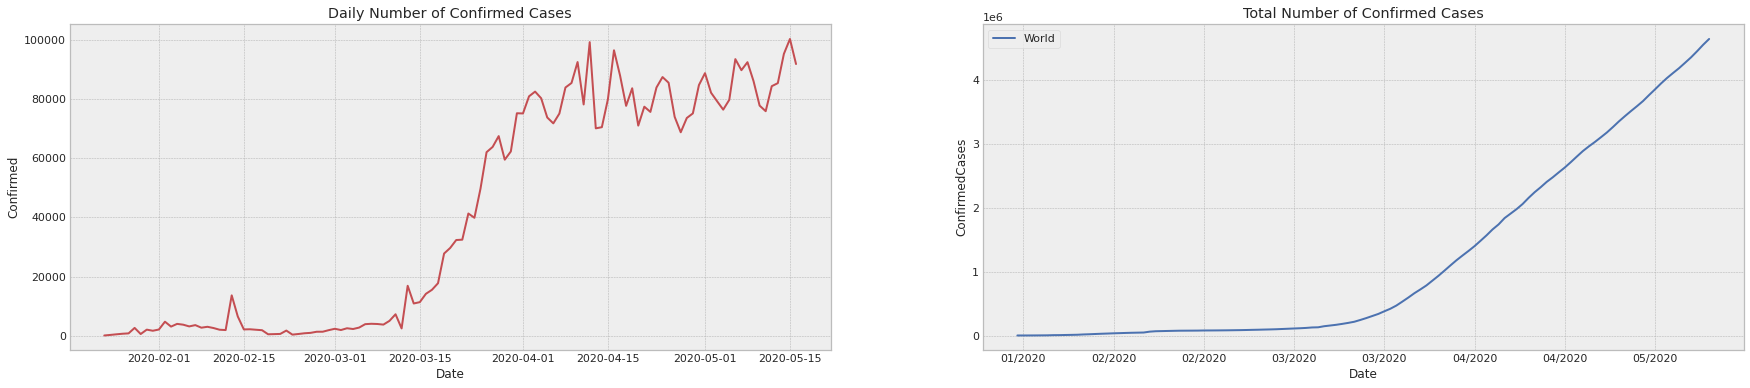

<Figure size 684x432 with 0 Axes>

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 6))

ax1.plot(cumulative_df.loc[1:, 'Date'], daily_df.loc[1:, 'Confirmed'], label="World", color="r")
ax1.set(xlabel="Date",
       ylabel="Confirmed",
       title="Daily Number of Confirmed Cases")

ax2.plot(cumulative_df['Date'].values, cumulative_df['Confirmed'], label="World", color="b")
ax2.set(xlabel="Date",
       ylabel="ConfirmedCases",
       title="Total Number of Confirmed Cases")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.legend()
plt.show()
plt.gcf().autofmt_xdate()

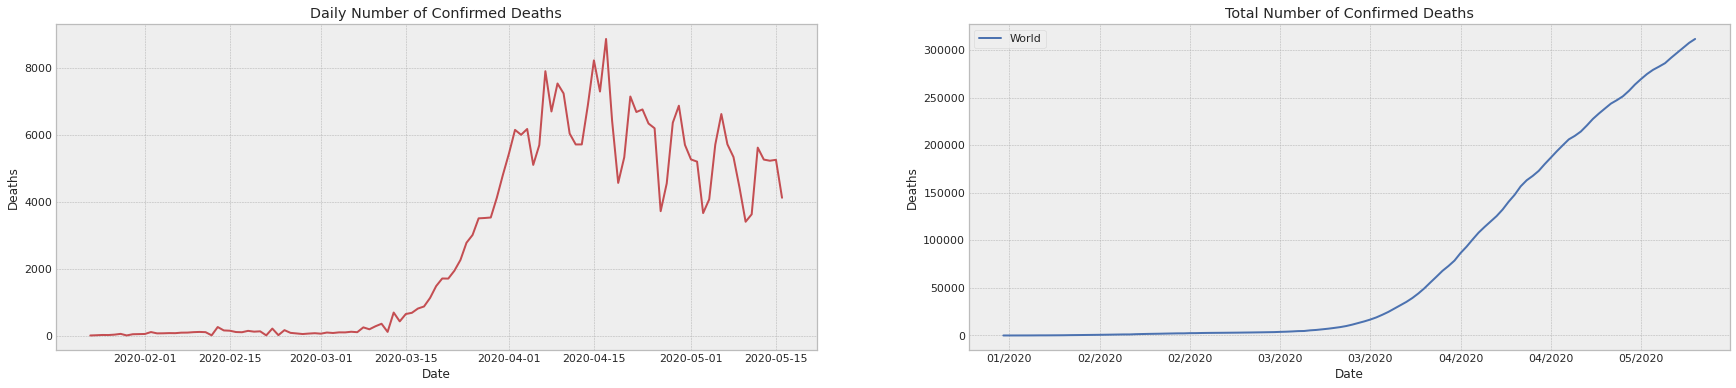

<Figure size 684x432 with 0 Axes>

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 6))

ax1.plot(cumulative_df.loc[1:, 'Date'], daily_df.loc[1:, 'Deaths'], label="World", color="r")
ax1.set(xlabel="Date",
       ylabel="Deaths",
       title="Daily Number of Confirmed Deaths")

ax2.plot(cumulative_df['Date'].values, cumulative_df['Deaths'], label="World", color="b")
ax2.set(xlabel="Date",
       ylabel="Deaths",
       title="Total Number of Confirmed Deaths")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.legend()
plt.show()
plt.gcf().autofmt_xdate()


In [0]:
def get_df_by_country(df_country, country, daily=True):
    # return country_by_daily.loc[(country_by_daily['Country/Region'] == country) & (country_by_daily['Confirmed'] > 0) & (country_by_daily['Date'] >= '2020-03-01')]
    tmp = df_country.loc[:, ['Date', 'Country/Region', 'Confirmed', 'Deaths', 'Recovered']].loc[(df_country['Country/Region'] == country)]
    tmp.index = np.arange(0, len(tmp))
    if daily:
        tmp[tmp.columns.difference(['Date', 'Country/Region'])] = tmp[tmp.columns.difference(['Date', 'Country/Region'])].diff(axis=0).fillna(0)
        tmp[tmp.select_dtypes(['float64']).columns] = tmp.select_dtypes(['float64']).apply(lambda x: x.astype('int64'))
        return tmp 
    else:
        return tmp

# Total confirmed cases: how rapidly have they increased compared to other countries?

In [12]:
top10_countries = df[df['Date'] == df['Date'].max()]
top10_countries = top10_countries.groupby('Country/Region', as_index=False)['Confirmed','Deaths'].sum()
top10_countries = top10_countries.nlargest(10, 'Confirmed')
top10_countries

,Country/Region,Confirmed,Deaths
174,US,1467820,88754
139,Russia,272043,2537
178,United Kingdom,241461,34546
23,Brazil,233511,15662
158,Spain,230698,27563
85,Italy,224760,31763
62,France,179630,27532
66,Germany,175752,7938
173,Turkey,148067,4096
81,Iran,118392,6937


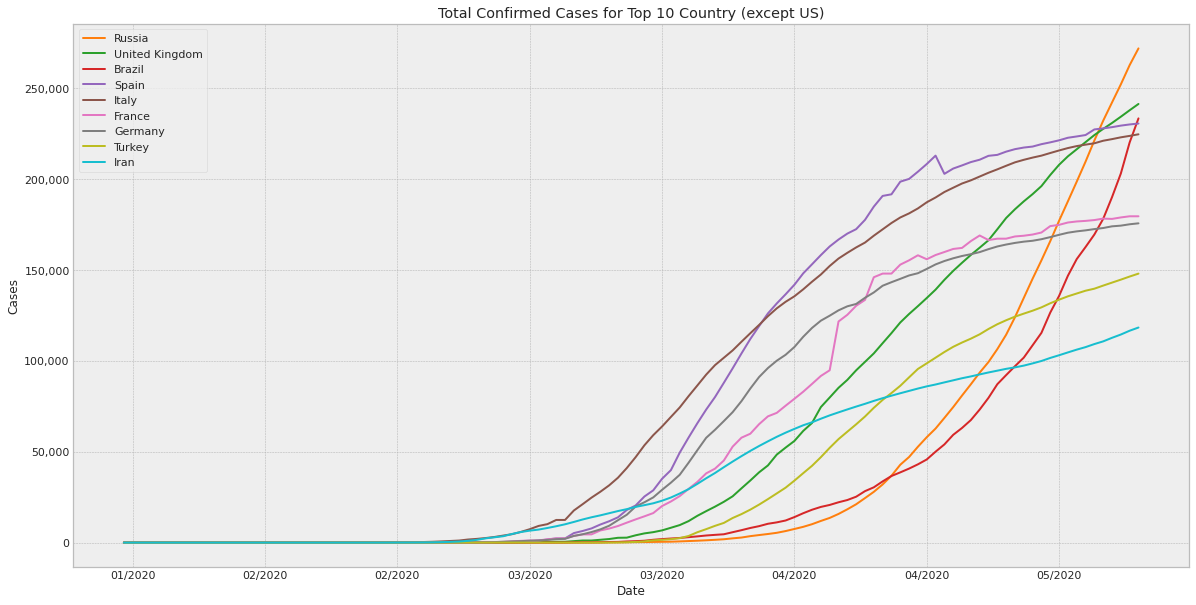

<Figure size 684x432 with 0 Axes>

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

for i, country_name in enumerate(top10_countries['Country/Region'].values):
    if i == 0:
        continue
    tmp_df = get_df_by_country(df, country_name, daily=False)
    ylabels = [format(label, ',.0f') for label in ax.get_yticks()]
    ax.set_yticklabels(ylabels)
    ax.plot(tmp_df['Date'].values, tmp_df['Confirmed'], label=country_name, color=colors[i])

ax.set(xlabel="Date",
       ylabel="Cases",
       title="Total Confirmed Cases for Top 10 Country (except US)")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.legend()
plt.show()
plt.gcf().autofmt_xdate()

# Model

https://dataplatform.cloud.ibm.com/exchange/public/entry/view/815137c868b916821dec777bdc23013c

https://machinelearningmastery.com/time-series-data-stationary-python/

Before we can build a model, we must ensure that the time series is stationary. First of all, let's explain what it means to be stationary of a time series data with the example below. 

![stationary](http://www.seanabu.com/img/Mean_nonstationary.png)
# New Section
The value shown in the plot is the mean of the time series data. As on the right, if this value **increases over time**, our data is not stationary. In other words, our data can be expressed **as a function of time**. However, in the graph on the left, this value **does not increase with time**, so it seems stationary.


# Decomposing the time series data for Turkey

In [14]:
df_turkey_daily = get_df_by_country(df, 'Turkey', daily=True)
df_turkey_cumulative = get_df_by_country(df, 'Turkey', daily=False)

display(df_turkey_daily.tail())
display(df_turkey_cumulative.tail())

,Date,Country/Region,Confirmed,Deaths,Recovered
111,2020-05-12,Turkey,1704,53,3109
112,2020-05-13,Turkey,1639,58,2826
113,2020-05-14,Turkey,1635,55,2315
114,2020-05-15,Turkey,1708,48,2103
115,2020-05-16,Turkey,1610,41,2004


,Date,Country/Region,Confirmed,Deaths,Recovered
111,2020-05-12,Turkey,141475,3894,98889
112,2020-05-13,Turkey,143114,3952,101715
113,2020-05-14,Turkey,144749,4007,104030
114,2020-05-15,Turkey,146457,4055,106133
115,2020-05-16,Turkey,148067,4096,108137


**Additive Model**

An additive model suggests that the components are added together as follows:

**y(t)** = *Level* + *Trend* + *Seasonality* + *Noise*

-> Residual yorumu

-> Seasonal yorumu

(116, 5)

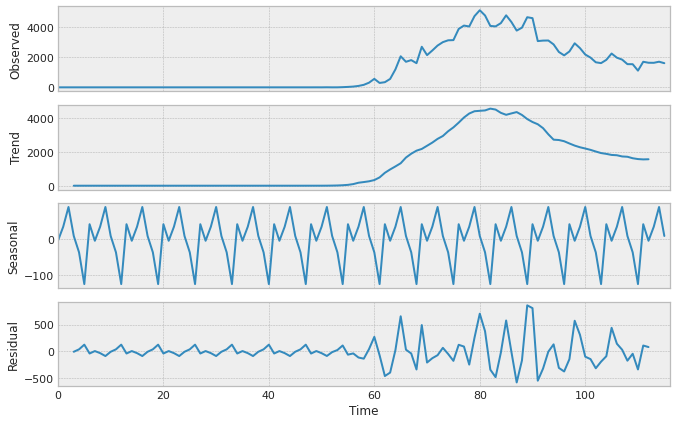

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
display(df_turkey_daily.shape)
fig=sm.tsa.seasonal_decompose(df_turkey_daily.Confirmed.values, model='additive', freq=7).plot()


When using a statistical model, we assume that the data are independent from each other. However, in this case, we know that each data point is dependent on a certain time. To use such a model, statistical properties must be constant over time. So the data must be stationary.

There are two methods to decide whether the data is stationary. One of them is to plot the mean and std. of the data depending on time. If these values remain constant over time, it is stationary. However, making visual inferences is not always accurate and feasible.

The other methos is the Augmented Dickey-Fuller test is a type of statistical test called a unit root test. The idea behind a unit root test is that it determines how strongly a time series is defined by a trend.

*   **Rolling Statistics:** Plot statistical properties then make visual inferences. The time series is stationary if they remain constant with time.
*   **Augmented Dickey-Fuller Test:** In order to call a data stationary, the test statistic value must be smaller than or closer the critical values and the p-value must be less than 0.05.

In [0]:
from statsmodels.tsa.stattools import adfuller

def is_stationary(df_ts):
    # starting from the first day, we calculate the mean 
    # and standard deviation in a 7-day window width called rolling mean/std.
    rolling_mean = df_ts.rolling(window=7).mean()
    rolling_std = df_ts.rolling(window=7).std()
    
    # Rolling Statistics:
    plt.plot(df_ts, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()
    
    # Augmented Dickey-Fuller Test:
    result = adfuller(df_ts)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


For the original data, we run the tests in the above function. We see that statistical properties increase with respect to time. In addition, in the ADF test, we see that the ADF Statistic value is greater than the critical values and the p-value is greater than 0.05. This indicates that the data is **not stationary**.

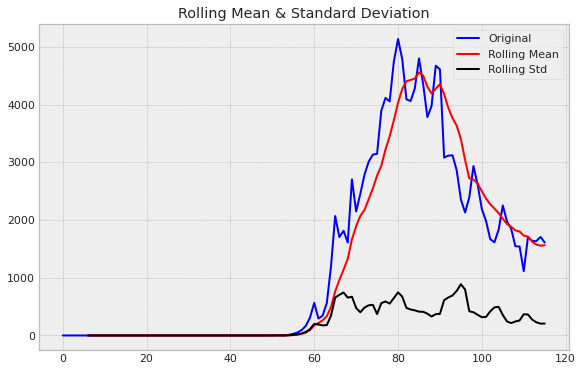

ADF Statistic: -1.9369547215587843
p-value: 0.31488103841793097
Critical Values:
	1%: -3.4936021509366793
	5%: -2.8892174239808703
	10%: -2.58153320754717


In [17]:
is_stationary(df_turkey_daily.Confirmed)

We need to **transform the data to stationary** before using our model. There are several methods for this. We will use **logarithmic** transformation from these. After taking the logarithm of the data, we also take the logarithms of rolling mean. Then we subtract this from the rolling log. mean. These stages enable us to discard the trend in the data.

In [0]:
turkey_daily_log = np.log(df_turkey_daily.loc[:, ['Confirmed']])
turkey_daily_log = turkey_daily_log.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

log_rolling_mean = turkey_daily_log.rolling(window=7).mean()
df_log_minus_mean = turkey_daily_log - log_rolling_mean
df_log_minus_mean = df_log_minus_mean.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

As seen below, according to ADF test, our statistical values are in the form of stationary time series data. Test statistics value is less than critical value and p-value is less than 0.05. We **obtained more stationary** data than the original data.

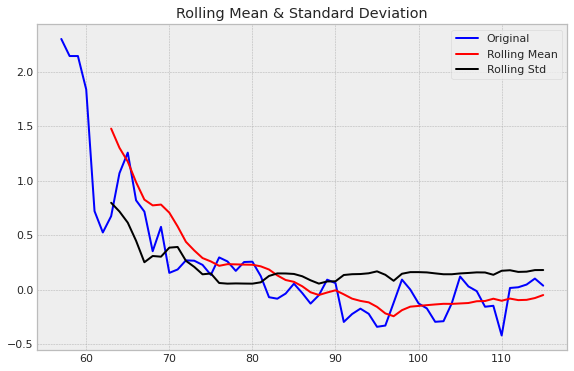

ADF Statistic: -4.48639557941454
p-value: 0.0002080748279385196
Critical Values:
	1%: -3.562878534649522
	5%: -2.918973284023669
	10%: -2.597393446745562


In [19]:
is_stationary(df_log_minus_mean.Confirmed)

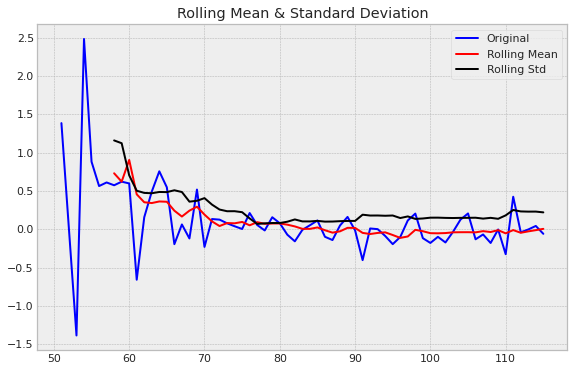

ADF Statistic: -4.5065272990105045
p-value: 0.00019136812969821089
Critical Values:
	1%: -3.560242358792829
	5%: -2.9178502070837
	10%: -2.5967964150943397


In [20]:
turkey_daily_log_shift = turkey_daily_log - turkey_daily_log.shift()
turkey_daily_log_shift = turkey_daily_log_shift.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
is_stationary(turkey_daily_log_shift.Confirmed)

# ARIMA

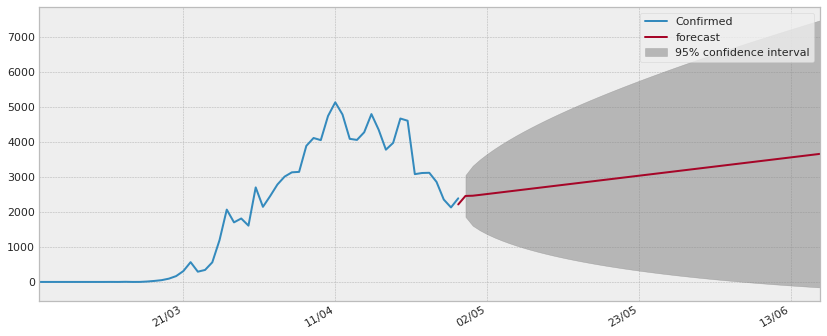

Mean absolute percentage error: 52.947683


In [30]:
date_idx = [116 + x for x in range(0,40)]
dates = pd.date_range(start='2020-01-22', end='2020-06-25')

def calculate_arima_by_country(_df, country_name, split_perc=0.85):

    df_ts = get_df_by_country(_df, country_name, daily=True)

    country_train = df_ts[:int(len(df_ts)*split_perc)].loc[:, 'Confirmed'].values
    country_train = pd.DataFrame(data=country_train[:], index=dates[:int(len(df_ts)*split_perc)], columns=['Confirmed'])
    country_test = df_ts[int(len(df_ts)*split_perc):].loc[:, 'Confirmed'].values

    model = ARIMA(country_train, order=(1,1,2))
    result = model.fit()
    fig, ax = plt.subplots(figsize=(14, 6))
    ax = country_train.loc['2020-03-01':].plot(ax=ax)
    fig = result.plot_predict(start=int(len(country_train)/1.01), end=int(len(country_train)* 1.5), 
                              ax=ax, plot_insample=False)
    predictions = result.forecast(steps=len(country_test))[0]
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=21))
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.show()

    # mean absolute percentage error (MAPE), is a measure of
    # prediction accuracy of a forecasting method in statistics
    print('Mean absolute percentage error: %f'%mean_absolute_percentage_error(country_test, predictions))
    return predictions

forecast_values = calculate_arima_by_country(df, 'Turkey', 0.85)
# amerika, türkiye...

# Seasonal ARIMA

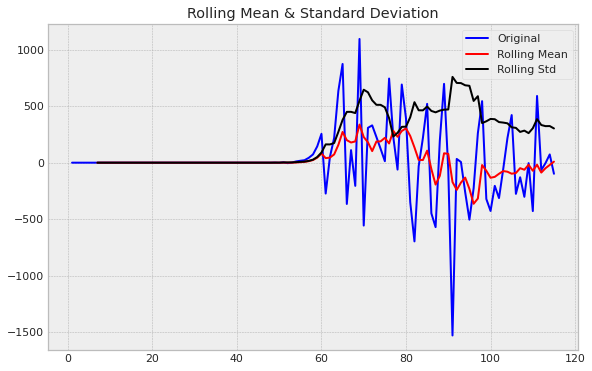

ADF Statistic: -3.403784098767173
p-value: 0.010830546374920228
Critical Values:
	1%: -3.4912451337340342
	5%: -2.8881954545454547
	10%: -2.5809876033057852


In [23]:
df_turkey_daily['first_diff'] = df_turkey_daily.Confirmed - df_turkey_daily.Confirmed.shift(1)
is_stationary(df_turkey_daily.first_diff.dropna(inplace=False))

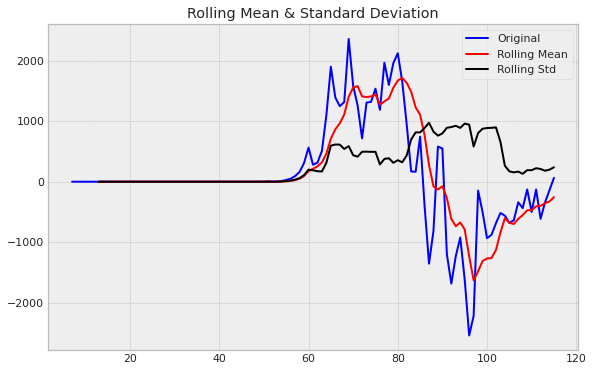

ADF Statistic: -3.430621514845586
p-value: 0.009958239993839706
Critical Values:
	1%: -3.5011373281819504
	5%: -2.8924800524857854
	10%: -2.5832749307479226


In [24]:
df_turkey_daily['seasonal_diff'] = df_turkey_daily.Confirmed - df_turkey_daily.Confirmed.shift(7)
is_stationary(df_turkey_daily.seasonal_diff.dropna(inplace=False))

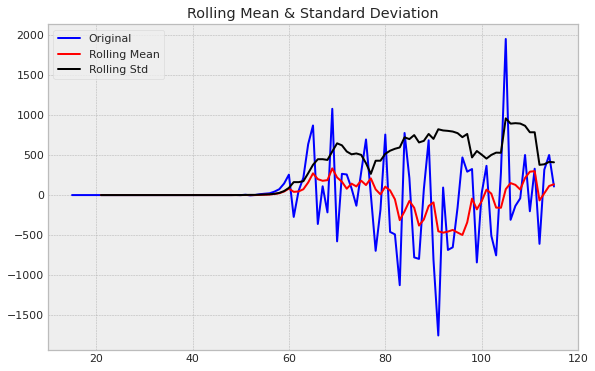

ADF Statistic: -2.9013729550135574
p-value: 0.04518857427257203
Critical Values:
	1%: -3.5078527246648834
	5%: -2.895382030636155
	10%: -2.584823877658872


In [25]:
df_turkey_daily['seasonal_first_diff'] = df_turkey_daily.first_diff - df_turkey_daily.first_diff.shift(14)
is_stationary(df_turkey_daily.seasonal_first_diff.dropna(inplace=False))

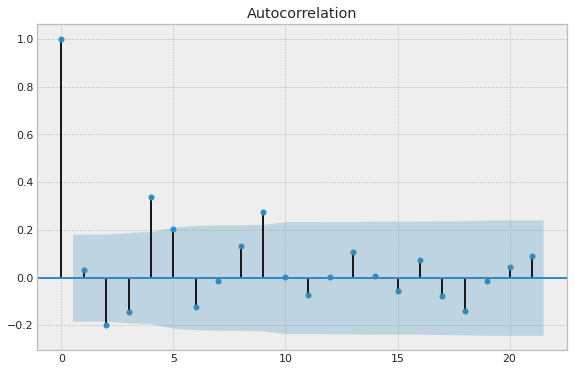

In [26]:
fig = sm.graphics.tsa.plot_acf(df_turkey_daily.Confirmed.diff().dropna())

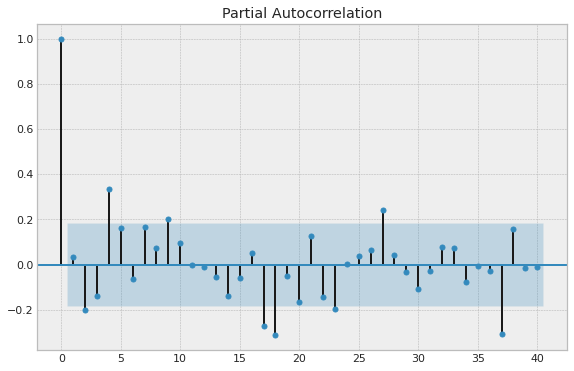

In [27]:
fig = sm.graphics.tsa.plot_pacf(df_turkey_daily.Confirmed.diff().dropna(), lags=40)

In [28]:
mod = sm.tsa.statespace.SARIMAX(df_turkey_daily.Confirmed, trend='n', order=(14,0,7))
results = mod.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:              Confirmed   No. Observations:                  116
Model:              SARIMAX(14, 0, 7)   Log Likelihood                -810.790
Date:                Tue, 19 May 2020   AIC                           1665.580
Time:                        10:58:30   BIC                           1726.159
Sample:                             0   HQIC                          1690.172
                                - 116                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2728      1.729      0.158      0.875      -3.117       3.663
ar.L2         -0.0426      0.552     -0.077      0.938      -1.124       1.039
ar.L3         -0.2152      0.583     -0.369      0.7

In [0]:
date_idx = [116 + x for x in range(0,40)]
dates = pd.date_range(start='2020-01-22', end='2020-06-25')
future = pd.DataFrame(index=date_idx, columns=df_turkey_daily.columns)

df_turkey_concat = pd.concat([df_turkey_daily, future])
df_turkey_concat['Date'] = dates
df_turkey_concat = df_turkey_concat.loc[:, ['Date', 'Country/Region', 'Confirmed' ]]

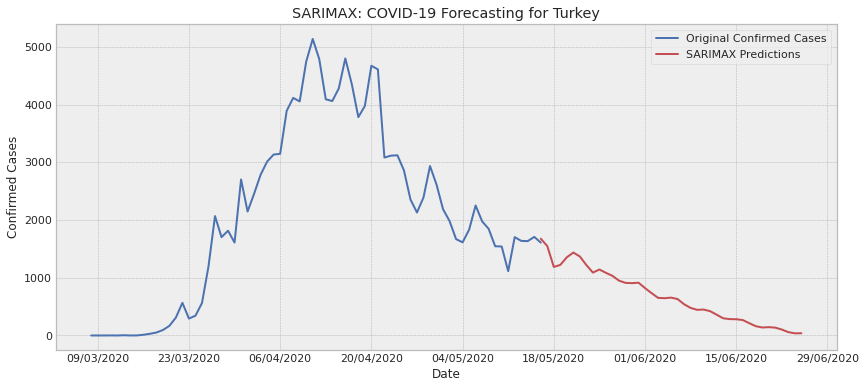

<Figure size 684x432 with 0 Axes>

In [32]:
df_turkey_concat['forecast'] = results.predict(start = 115, end = 155)

fig, ax = plt.subplots(figsize=(14, 6))
df_turkey_concat = df_turkey_concat.iloc[-110:]
ax.plot(df_turkey_concat['Date'].values, df_turkey_concat['Confirmed'], label='Original Confirmed Cases', color='b')
ax.plot(df_turkey_concat['Date'].values, df_turkey_concat['forecast'], label='SARIMAX Predictions', color='r')

ax.set(xlabel="Date",
       ylabel="Confirmed Cases",
       title="SARIMAX: COVID-19 Forecasting for Turkey")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.legend()
plt.show()
plt.gcf().autofmt_xdate()

# DENEME

useful verisetindeki karantina (to_categorical), government response, ülke nüfusu, ortalama yaş gibi etkenleri asıl veriye katarak herhangi bir ülke özelinde linear regression modeli oluştur.

cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']
details['total_cases']=details['Confirmed'] + details['Deaths'] + details['Recovered']
# Active Case = confirmed - deaths - recovered
details['Active'] = details['Confirmed'] - details['Deaths'] - details['Recovered']
# replacing Mainland china with just China
details['Country/Region'] = details['Country/Region'].replace('Mainland China', 'China')

# filling missing values 
details[['Province/State']] = details[['Province/State']].fillna('')
details[cases] = details[cases].fillna(0)

# fixing datatypes
details['Recovered'] = details['Recovered'].astype(int)

details.sample(6)